# Urban Air Pollution Challenge
Can you predict air quality in cities around the world using satellite data?

In [1]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import accuracy_score
# import pandas_profiling

In [2]:
df = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 82 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Place_ID X Date                                      30557 non-null  object 
 1   Date                                                 30557 non-null  object 
 2   Place_ID                                             30557 non-null  object 
 3   target                                               30557 non-null  float64
 4   target_min                                           30557 non-null  float64
 5   target_max                                           30557 non-null  float64
 6   target_variance                                      30557 non-null  float64
 7   target_count                                         30557 non-null  int64  
 8   precipitable_water_entire_atmosphere                 30557 non-nul

<AxesSubplot:>

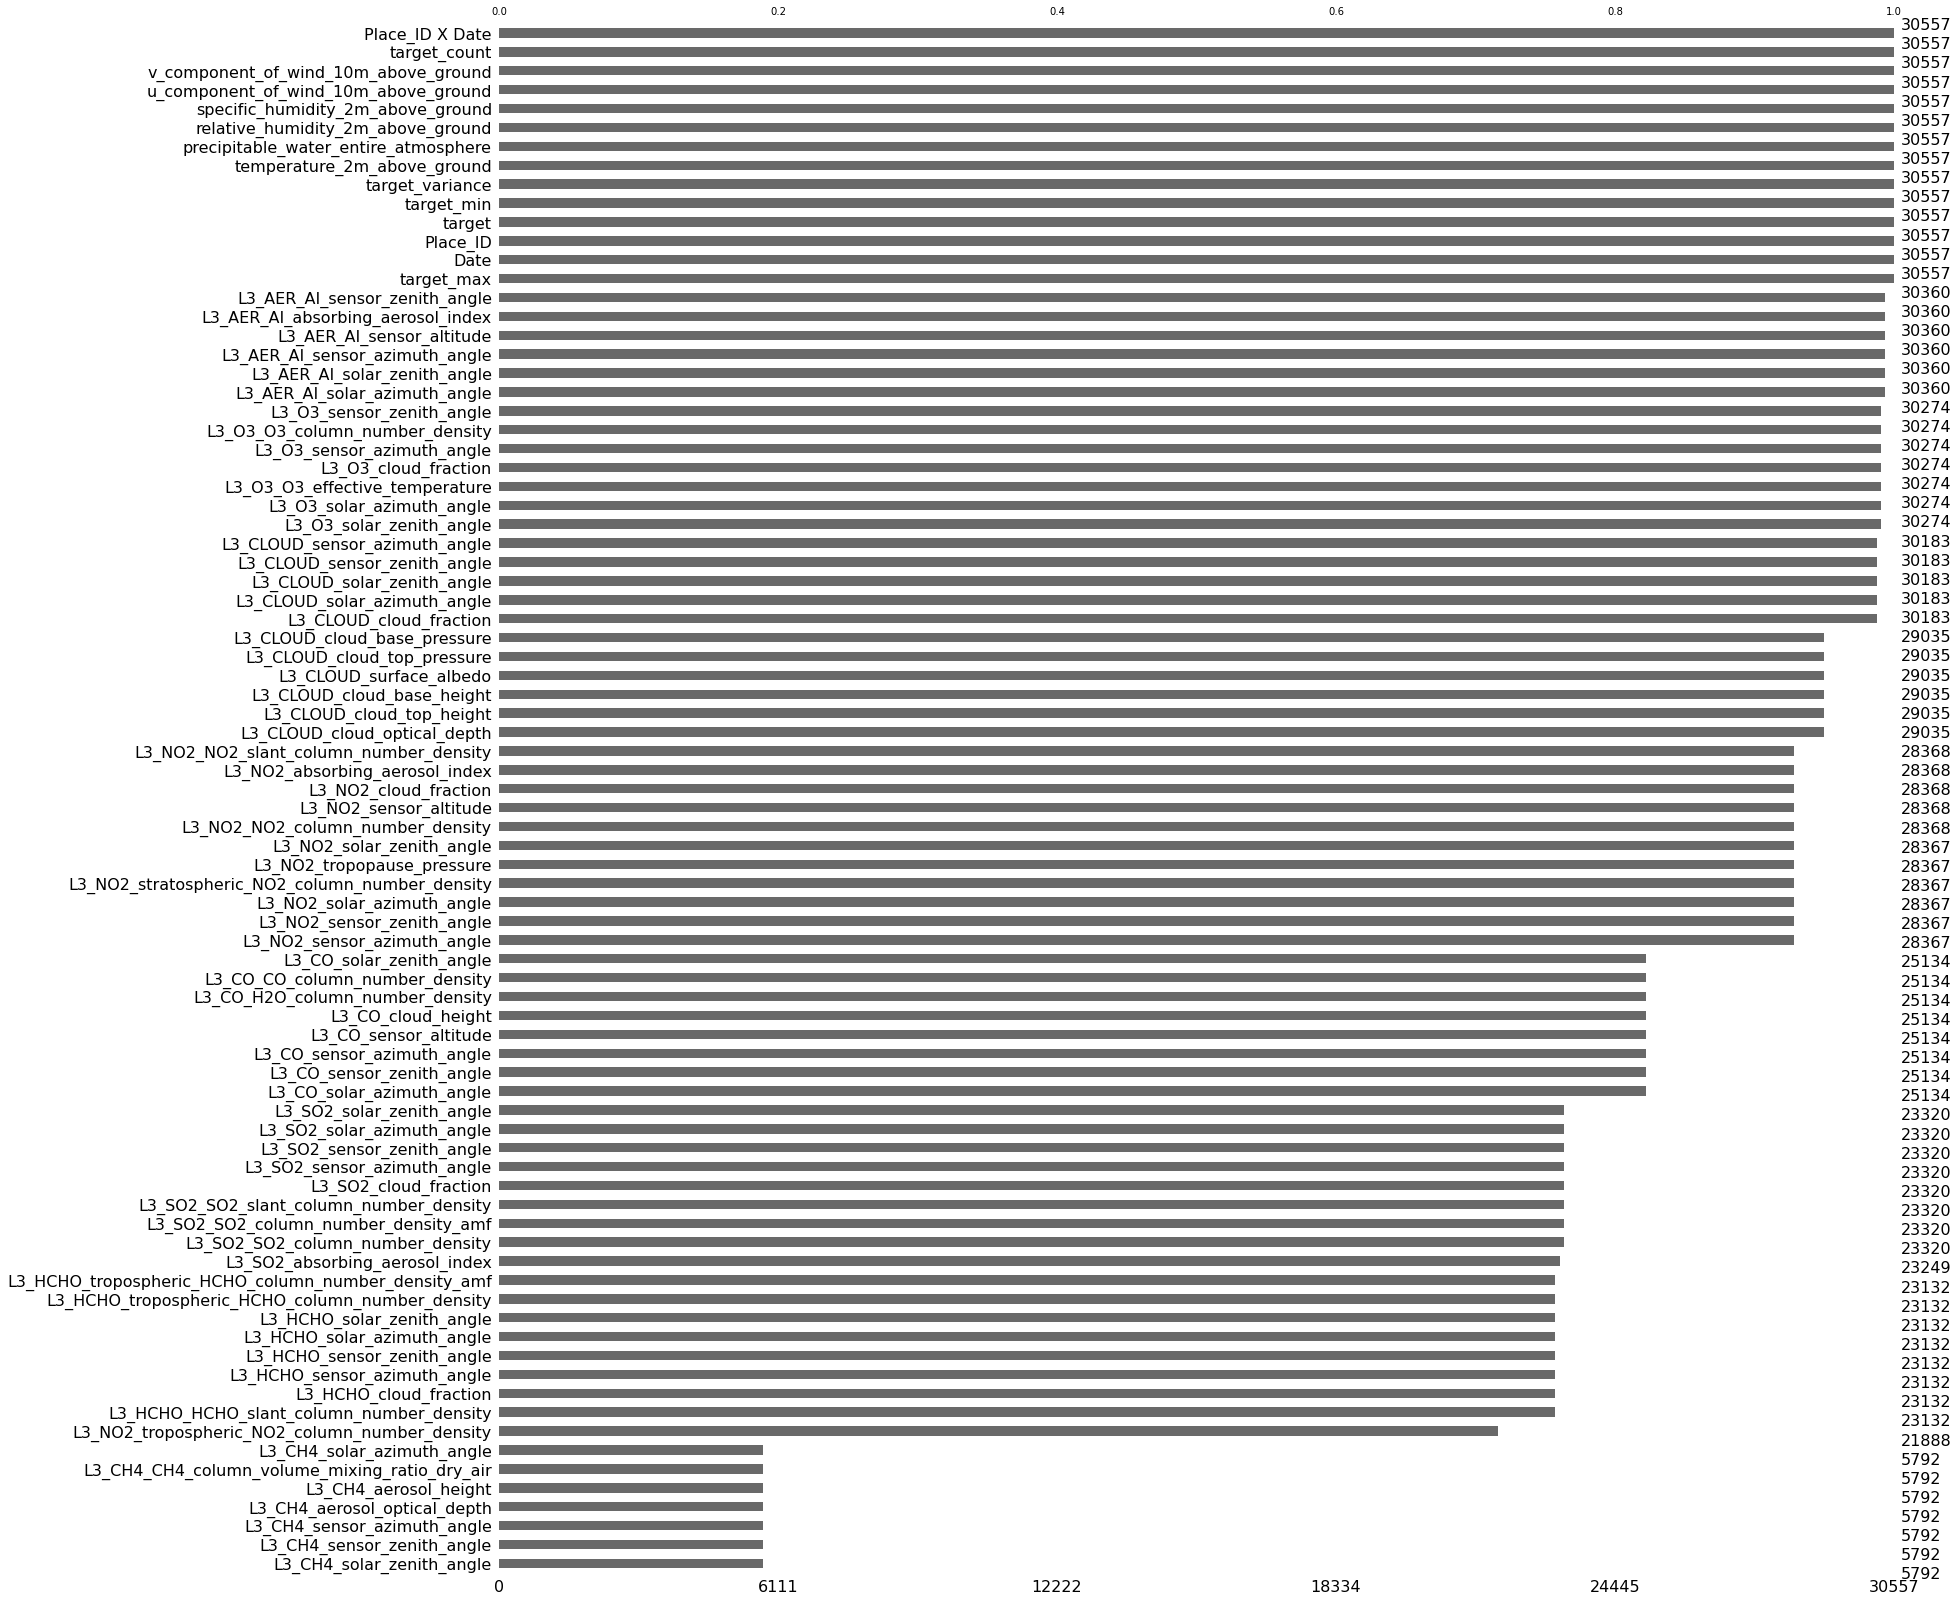

In [4]:
msno.bar(df, sort="ascending")

In [5]:
(df.isnull().sum()  / len(df) * 100).sort_values(ascending=False).head(10)

L3_CH4_solar_zenith_angle                              81.045260
L3_CH4_solar_azimuth_angle                             81.045260
L3_CH4_sensor_zenith_angle                             81.045260
L3_CH4_sensor_azimuth_angle                            81.045260
L3_CH4_aerosol_optical_depth                           81.045260
L3_CH4_aerosol_height                                  81.045260
L3_CH4_CH4_column_volume_mixing_ratio_dry_air          81.045260
L3_NO2_tropospheric_NO2_column_number_density          28.369932
L3_HCHO_tropospheric_HCHO_column_number_density_amf    24.298851
L3_HCHO_tropospheric_HCHO_column_number_density        24.298851
dtype: float64

In [49]:
def clean_df(train_df, test_df, target_col='target', threshold=0.80):
    
    # Drop unique columns
    train_df = train_df.drop(['Place_ID X Date', 'Date', 'Place_ID','target_count', 'target_max', 'target_min', 'target_variance'], axis=1)
    test_df = test_df.drop(['Place_ID X Date', 'Date', 'Place_ID'], axis=1)
    
    # Drop columns with more than 80% missing values
    high_missing_cols_train = train_df.isnull().mean() > 0.8
    train_df = train_df.loc[:, ~high_missing_cols_train]
    high_missing_cols_test = test_df.isnull().mean() > 0.8
    test_df = test_df.loc[:, ~high_missing_cols_test]

    # Impute the remaining missing values with the mean, except for the target column.
    train_df.loc[:, ~train_df.columns.isin([target_col])] = train_df.fillna(train_df.mean())
    train_df.loc[:, ~train_df.columns.isin([target_col])] = train_df.loc[:, ~train_df.columns.isin([target_col])].apply(lambda col: col.fillna(col.mean()), axis=0)
    test_df = test_df.fillna(test_df.mean())

    # Remove outliers by 'target' in the train set.
    low_train, high_train = train_df['target'].quantile([0.0, 0.99979])
    mask_train = train_df['target'].between(low_train, high_train)
    train_df = train_df[mask_train]

    # Drop columns that are highly correlated with the target column in the train set.
    corr_train = train_df.corr()
    mask_train = np.triu(np.ones_like(corr_train, dtype=bool))
    tri_df_train = corr_train.mask(mask_train)
    to_drop_train = [c for c in tri_df_train.columns if any(tri_df_train[c] > threshold) and c != target_col]
    train_df = train_df.drop(to_drop_train, axis=1)
    # Drop the corresponding columns from the test set
    test_df = test_df.drop(to_drop_train, axis=1, errors='ignore')  # Use errors='ignore' to handle cases where a column doesn't exist in the test set
    
#     # Use only the common columns between train and test sets in the test set.
#     common_cols = train_df.columns.intersection(test_df.columns)
#     test_df = test_df[common_cols]

    return train_df, test_df

In [40]:
processed_train, processed_test = clean_df(df, test, target_col='target')

In [41]:
processed_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30550 entries, 0 to 30556
Data columns (total 38 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   target                                               30550 non-null  float64
 1   relative_humidity_2m_above_ground                    30550 non-null  float64
 2   temperature_2m_above_ground                          30550 non-null  float64
 3   u_component_of_wind_10m_above_ground                 30550 non-null  float64
 4   v_component_of_wind_10m_above_ground                 30550 non-null  float64
 5   L3_NO2_absorbing_aerosol_index                       30550 non-null  float64
 6   L3_NO2_cloud_fraction                                30550 non-null  float64
 7   L3_NO2_sensor_altitude                               30550 non-null  float64
 8   L3_NO2_solar_azimuth_angle                           30550 non-nul

In [42]:
processed_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16136 entries, 0 to 16135
Data columns (total 37 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   relative_humidity_2m_above_ground                    16136 non-null  float64
 1   temperature_2m_above_ground                          16136 non-null  float64
 2   u_component_of_wind_10m_above_ground                 16136 non-null  float64
 3   v_component_of_wind_10m_above_ground                 16136 non-null  float64
 4   L3_NO2_absorbing_aerosol_index                       16136 non-null  float64
 5   L3_NO2_cloud_fraction                                16136 non-null  float64
 6   L3_NO2_sensor_altitude                               16136 non-null  float64
 7   L3_NO2_solar_azimuth_angle                           16136 non-null  float64
 8   L3_NO2_stratospheric_NO2_column_number_density       16136 non-nul

## visualization

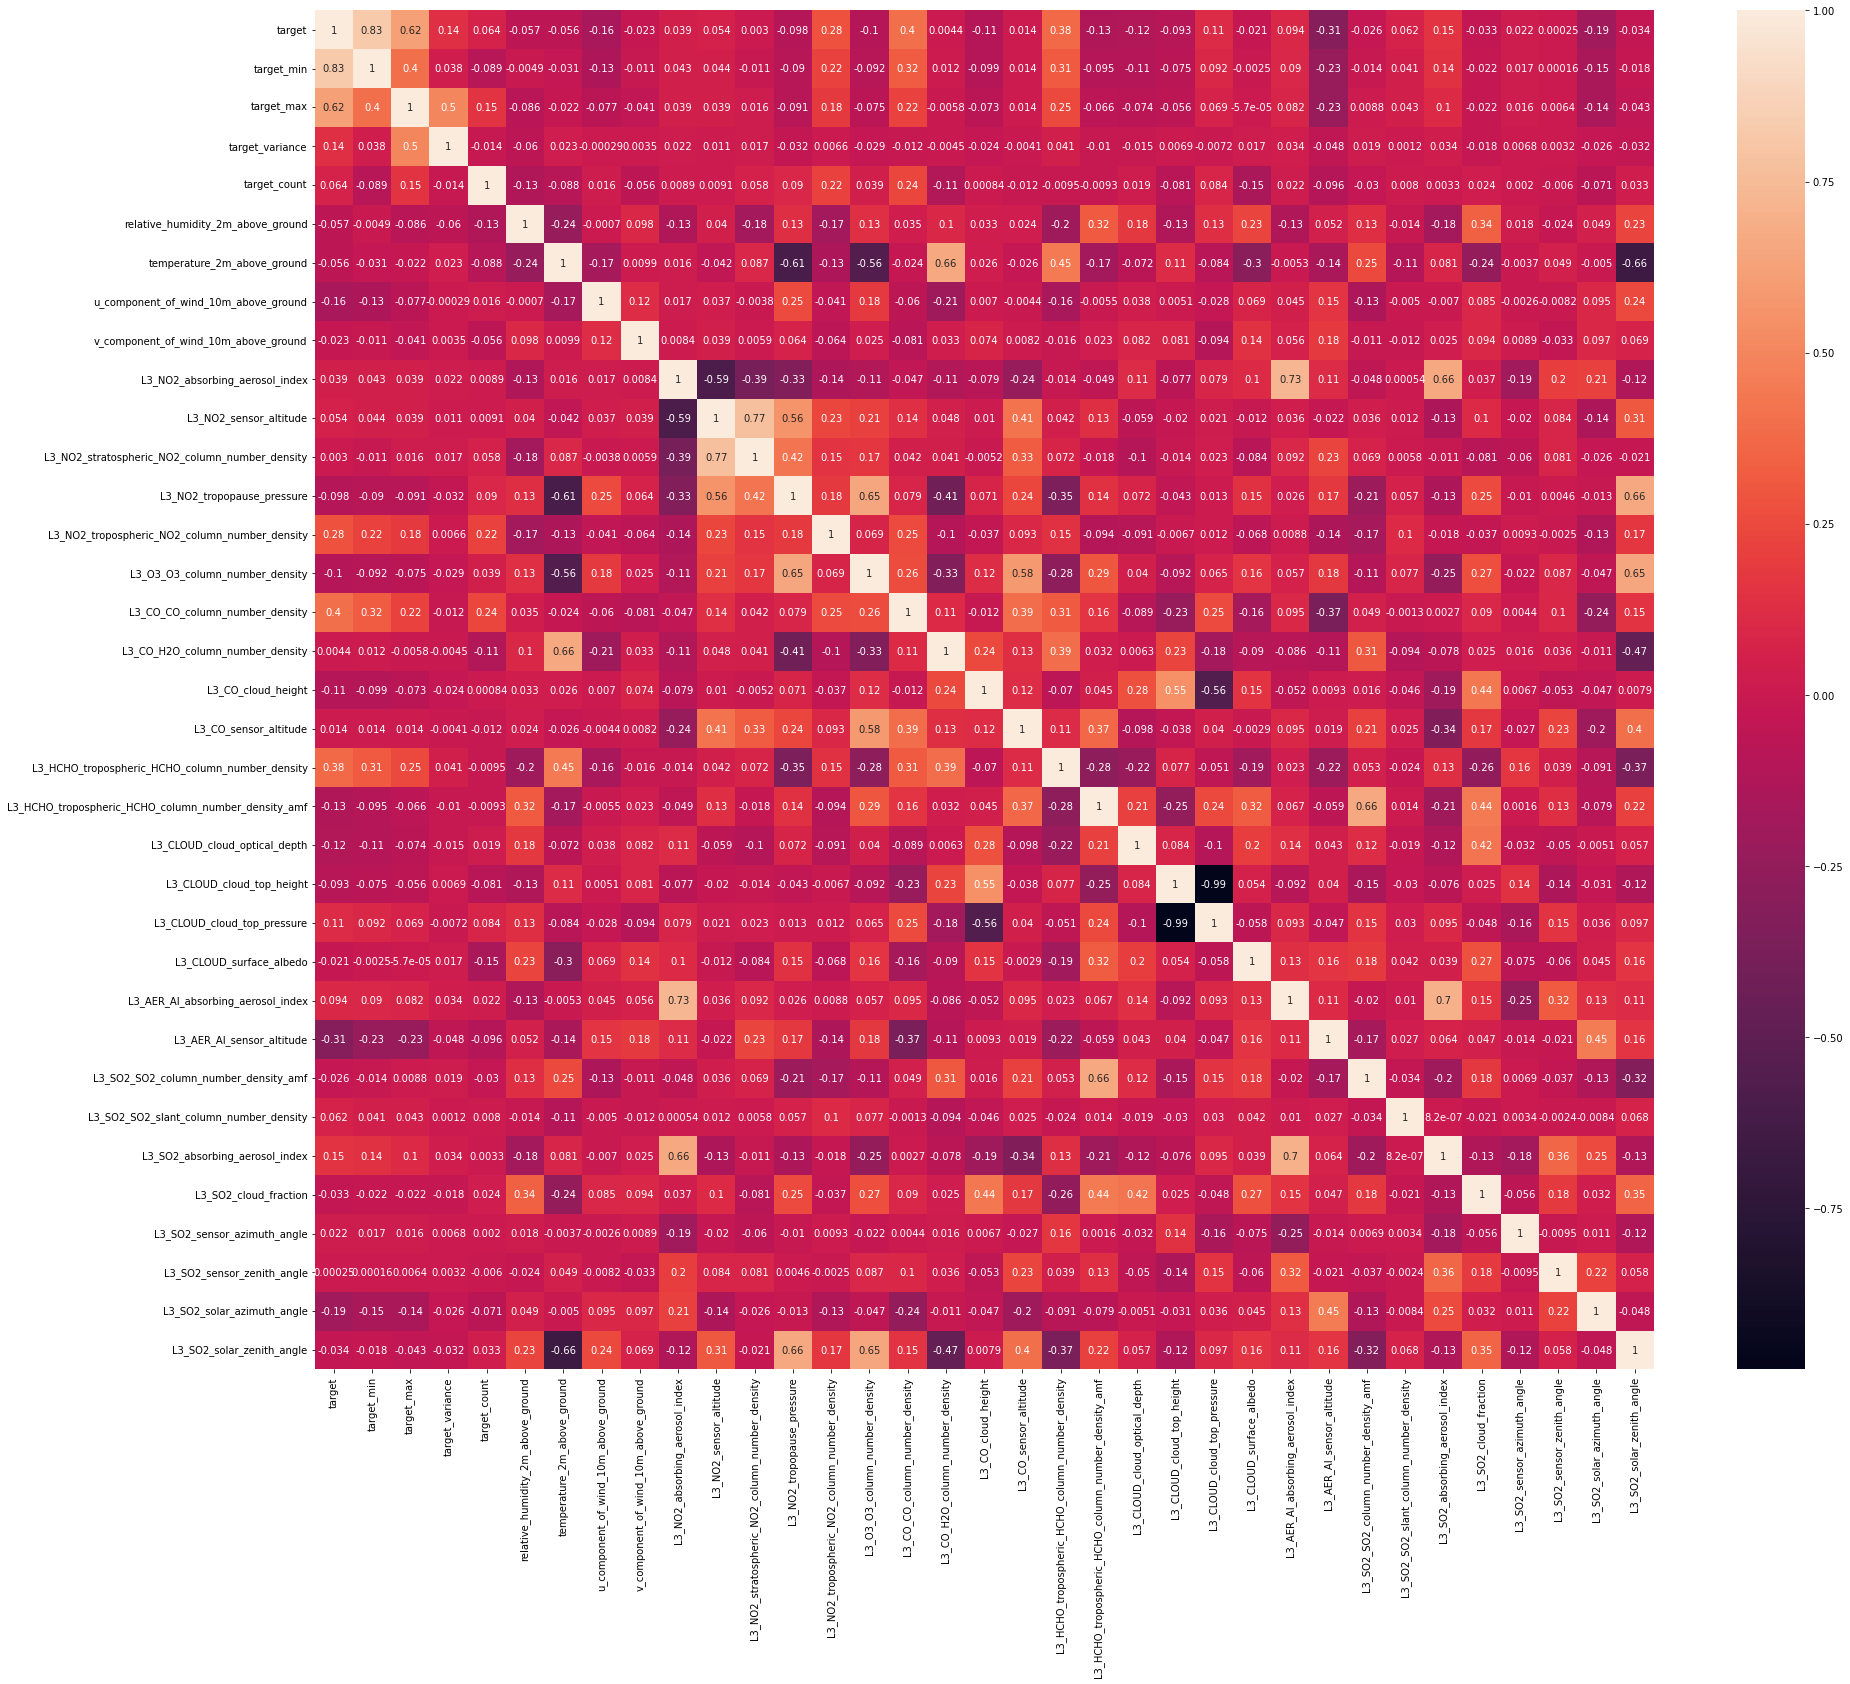

In [10]:
plt.figure(figsize = (30, 25))
sns.heatmap(cleaned_df.corr(), annot=True)
plt.show()

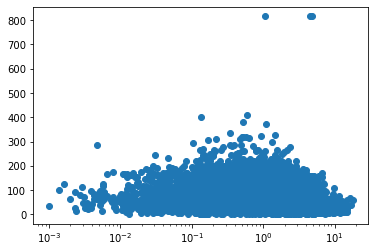

In [11]:
plt.xscale("log")
plt.scatter(x = df['u_component_of_wind_10m_above_ground'], y = df["target"])

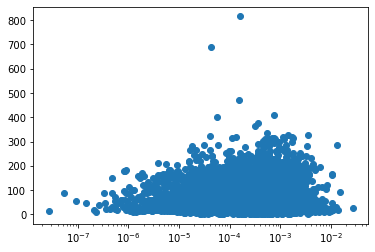

In [12]:
plt.xscale("log")
plt.scatter(x = df['L3_SO2_SO2_column_number_density'], y = df["target"])

## GradientBoostingRegressor

In [50]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import numpy as np

Xr = processed_train.drop(['target'], axis=1)
yr = processed_train['target']

SEED = 123
X_train, X_test, y_train, y_test = train_test_split(Xr, yr, test_size=0.3, random_state=SEED)

gb = GradientBoostingRegressor(max_depth=4, 
            n_estimators=200,
            learning_rate = 0.1,
            subsample = 0.8,  
            min_samples_split = 2,
            min_samples_leaf = 1,  
            max_features = 'sqrt', 
            random_state=SEED)
# Fit rf to the training set    
gb.fit(X_train, y_train) 

# Predict the test set labels
y_pred = gb.predict(X_test)

# Evaluate the test set RMSE
score = gb.score(X_train, y_train)
rmse_test = (MSE(y_test,y_pred)**(1/2))
# Print rmse_test
print("R-squared:", score)
print('Test set RMSE of gb: {:.2f}'.format(rmse_test))
print("Accuracy on training set: %.3f" % gb.score(X_train, y_train))
print("Accuracy on test set: %.3f" % gb.score(X_test, y_test))

R-squared: 0.6322408933717808
Test set RMSE of gb: 30.18
Accuracy on training set: 0.632
Accuracy on test set: 0.571


## Stochastic GradientBoostingRegressor

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

Xg = processed_train.drop(['target'], axis=1)
yg = processed_train['target']

SEED = 123
X_train, X_test, y_train, y_test = train_test_split(Xg, yg, test_size=0.3, random_state=SEED)

sgb = GradientBoostingRegressor(max_depth=4, 
            n_estimators=300,
            subsample=0.8,
            max_features=0.2,
            random_state=SEED)

# Fit rf to the training set    
sgb.fit(X_train, y_train) 

# Predict the test set labels
y_pred = sgb.predict(X_test)

# Evaluate the test set RMSE
score = sgb.score(X_train, y_train)
rmse_test = MSE(y_test,y_pred)**(1/2)
# Print rmse_test
print("R-squared:", score)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print("Accuracy on training set: %.3f" % sgb.score(X_train, y_train))
print("Accuracy on test set: %.3f" % sgb.score(X_test, y_test))

R-squared: 0.6735428880113294
Test set RMSE of rf: 29.55
Accuracy on training set: 0.674
Accuracy on test set: 0.589


## xgboostRegressor

In [52]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

Xb = processed_train.drop(['target'], axis=1)
yb = processed_train['target']

X_train, X_test, y_train, y_test = train_test_split(Xb, yb, test_size=0.2, random_state=123)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror',
                          n_estimators=10,
                          seed=123,
                          reg_alpha=0.1, 
                          reg_lambda=1.0)
# Fit the regressor to the training set
xg_reg.fit(X_train,y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)
score = xg_reg.score(X_train, y_train)
# Compute the rmse: rmse
rmse = np.sqrt(MSE(y_test, preds))
print("R-squared:", score)
print("RMSE: %f" % (rmse))
print("Accuracy on training set: %.3f" % xg_reg.score(X_train, y_train))
print("Accuracy on test set: %.3f" % xg_reg.score(X_test, y_test))

R-squared: 0.5787048899019146
RMSE: 30.894422
Accuracy on training set: 0.579
Accuracy on test set: 0.549


## report

In [67]:
test.target = gb.predict(processed_test)

In [55]:
test.target = sgb.predict(processed_test)

C:\Users\HP\AppData\Local\Temp\ipykernel_12484\2991511046.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  test.target = sgb.predict(processed_test)


In [64]:
test.target = xg_reg.predict(processed_test)

In [68]:
# Create submission DataFrame
submission = pd.DataFrame({"Place_ID X Date": test["Place_ID X Date"],
                           "target": test.target})

In [69]:
submission.to_csv('submission_gb.csv', index = False)